# MSIS680 Advanced Machine Learning

## Lab 4 - Natrual Lanuage Processing

In this lab, we will learn how to process text data to extract useful information. We will then perform sentiment analysis using multiple methods and compare the performance of these different approaches.

Before everything, do the following steps:
1. click `Runtime` --> `change_runtime_type` --> enable GPU access.
2. download the three text files from blackboard and upload to your colab environment.

**Overview**
- Text Preprocessing
    - Tip Mining with POS Tagging
- Predictive Analysis
    - Dictionary
    - BOW + RandomForest
    - TFIDF + RandomForest
    - Pretrained Naive Bayes (TextBlob)
    - Glove Word Embeddings
    - Pretrained RoBERTa-large for sentiment analysis

In [ ]:
! pip install wordcloud
! pip install torchtext
! pip install transformers[torch]
! pip install evaluate
! pip install datasets

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

## "Singapore Airlines Reviews" dataset
The dataset we will use is the "Singapore Airlines Reviews" dataset, which aggregates 10,000 anonymized customer reviews, providing a broad perspective on the passenger experience with Singapore Airlines.
Extracting useful information from such customer reviews is very helpful for improving customer experience and operational efficiency.

**Column Descriptors**:
- published_date: Date and time of review publication.
- published_platform: Platform where the review was posted.
- rating: Customer satisfaction rating, from 1 (lowest) to 5 (highest).
- type: Specifies the content as a review.
- text: Detailed customer feedback.
- title: Summary of the review.
- helpful_votes: Number of users finding the review helpful.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
data = pd.read_csv("singapore_airlines_reviews.csv")
data.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


## Text Preprocessing

In [ ]:
data['published_date'] = pd.to_datetime(data['published_date'])   # parse date into timestamps
data["title"] = data["title"].astype(str)
data["text"] = data["text"].astype(str)
data['content_all'] = data['title'] + ' ||||| ' + data['text']
data.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,sentiment,content_all
0,2024-03-12 14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,0,Ok ||||| We used this airline to go from Singa...
1,2024-03-11 19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,1,The service in Suites Class makes one feel lik...
2,2024-03-11 12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,0,"Don’t give them your money ||||| Booked, paid ..."
3,2024-03-11 07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,1,Best Airline in the World ||||| Best airline i...
4,2024-03-10 05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,0,Premium Economy Seating on Singapore Airlines ...


<Axes: xlabel='rating'>

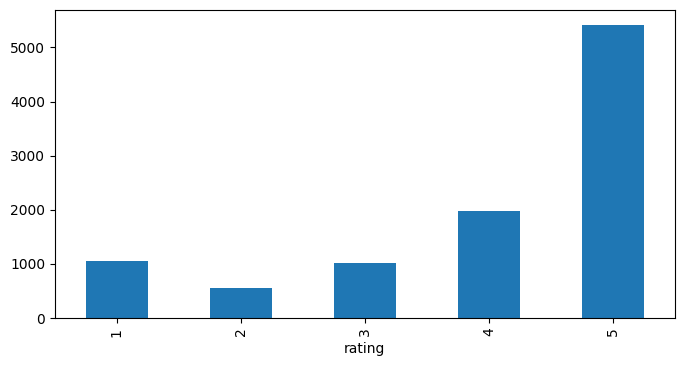

In [ ]:
## check the distribution of rating
data['rating'].value_counts().sort_index().plot(kind='bar',figsize=(8,4))

<Axes: xlabel='year'>

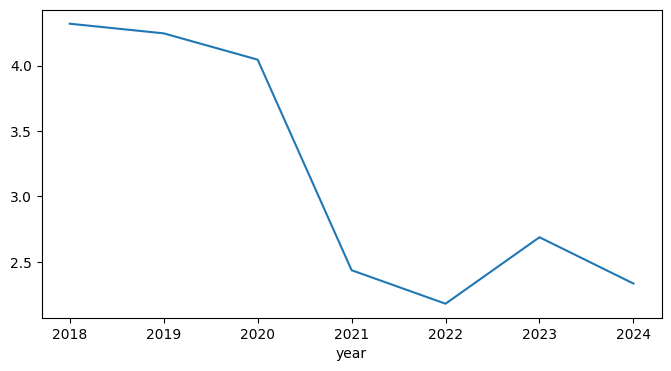

In [ ]:
# check the distribution of rating over years
data['year'] = data['published_date'].apply(lambda x: x.year)
data.groupby("year")['rating'].mean().plot(figsize=(8,4))

- We observe a declining trend in customer ratings of the airline's service. To better understand the reasons behind this trend, let's analyze the content of these reviews.
- A convenient way to quickly inspect the content is by using a **Word Cloud**, which extracts frequent *n-grams* from text input and visualizes them in a diagram. In a Word Cloud, n-grams with higher frequencies appear in a larger font size.

(-0.5, 399.5, 199.5, -0.5)

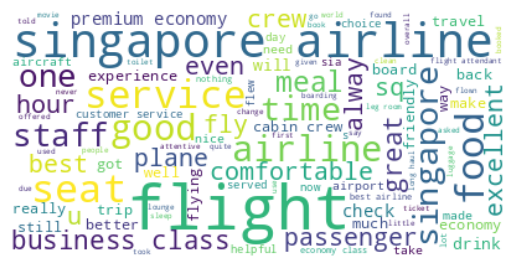

In [ ]:
## let's draw a wordcloud of all text
text = ' '.join(data['content_all'].astype(str)).lower()

from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

From the word cloud above, we can see that people mostly talked about the positive aspects of the airline. However, our interest lies in identifying the areas that need improvement based on customer feedback.

**How to get a word cloud regarding the aspects people critisize about?**

- Possiblely generating the word cloud with only negative reviews.

### Practice 1 - Generate a Word Cloud with Negative Reviews

- Generate Word Cloud with negative reviews (rating <=3)

(-0.5, 399.5, 199.5, -0.5)

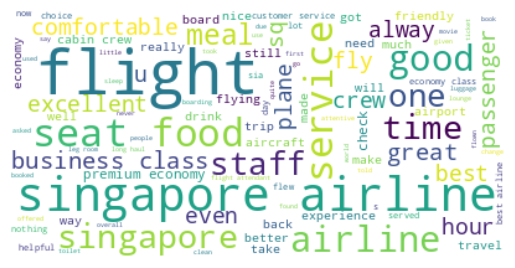

In [ ]:
## Your code here

mask = data['rating'] <= 3

negative_reviews = data[mask]['content_all']

negative_reviews

from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

 The most popular words includes "flight," "service," "seat," and "food" indicate the main aspects of the flight experience discussed in negative reviews. "Singapore Airline" is central and large, suggesting it is frequently mentioned.

 Words like "good," "excellent," and "great" might seem positive, but their presence in a negative review set could highlight the context ambiguity.

### Tip Mining with POS Tagging

Now, interpreting the above word cloud, we learn that people is critizing the customer services, something about food, plane, seat, and hours. Yet, the results are still vague and we don't know where to start interpret. Also, there are many non-relevant information such as "really", "use", "even", etc.

To improve this, we need some proper preprocessing of the text and only include relevant information. That involve the Tokenization and Part-of-Speech Tagging.

We are going to use `spaCy` for that. `spaCy` is a very popular package for advanced NLP (Tokenization, POS Tagging, Lemmatization, dependency parsing, etc.) that covers many languages.

Check here for a full list of features it offers:
- https://spacy.io/usage/spacy-101

In [ ]:
## import spacy
import spacy
from pprint import pp as pprint

## initialize the NLP engine to be english
nlp = spacy.load("en_core_web_sm")

In [ ]:
text = data['text'][4]
pprint(text)

('Premium Economy Seating on Singapore Airlines has narrow seats and poor leg '
 'room compared to Air NZ or Virgin.  Drinks served in plastic beakers, roast '
 'chicken tough as was the meat in the noodle dinner.  Orange juice concoction '
 'was not a premium offering.  Toilets - we had to walk half way back down the '
 'Economy cabin to queue for the toilet.  One toilet on the plane was not '
 'working. Having flown with Air NZ the day before the difference in amenities '
 'and poor value for money was apparent with Singapore Airlines.  Poor Kris '
 "Flyer website if you wish to upgrade it doesn't work!")


In [ ]:
## let's see its basic functionality with POS tagging
doc = nlp(text)
for token in doc[:20]:
    print(" --> ".join([token.text, token.pos_, token.tag_]))

Premium --> PROPN --> NNP
Economy --> PROPN --> NNP
Seating --> PROPN --> NNP
on --> ADP --> IN
Singapore --> PROPN --> NNP
Airlines --> PROPN --> NNP
has --> VERB --> VBZ
narrow --> ADJ --> JJ
seats --> NOUN --> NNS
and --> CCONJ --> CC
poor --> ADJ --> JJ
leg --> NOUN --> NN
room --> NOUN --> NN
compared --> VERB --> VBN
to --> ADP --> IN
Air --> PROPN --> NNP
NZ --> PROPN --> NNP
or --> CCONJ --> CC
Virgin --> PROPN --> NNP
. --> PUNCT --> .


Now, we want to extract short, concrete and informative word segments (Also called "Tips") that follow certain POS patterns. For example, "narrow seats" is an informative segments that the customer complaining about, similar with "poor leg room", they all follow a POS pattern `ADJ + NOUN`, and we can extract them all togther by matching `token.pos_` sequence.

In [ ]:
def extract_tips(nlp, review_text):
    # Process the review text
    doc = nlp(review_text)
    # Define the POS tagging patterns for tips
    tip_patterns = [
        [{"POS": "ADJ"}, {"POS": "NOUN"}],  # e.g., narrow seats
        [{"POS": "ADJ"}, {"POS": "NOUN"}, {"POS": "NOUN"}], # poor leg room
        [{"POS": "VERB"}, {"POS": "ADJ"}, {"POS": "NOUN"}], # try delicious food
        [{"POS": "VERB"}, {"POS": "NOUN"}, {"POS": "ADJ"}], # Visit museum stunning
        [{"POS": "ADV"}, {"POS": "VERB"}, {"POS": "NOUN"}], # Quickly grab tickets
        [{"POS": "NOUN"}, {"POS": "ADP"}, {"POS": "NOUN"}], # Plenty of parking
        [{"POS": "VERB"}, {"POS": "NOUN"}, {"POS": "NOUN"}], # Bring sunscreen hat
        [{"POS": "ADJ"}, {"POS": "NOUN"}, {"POS": "ADP"}, {"POS": "NOUN"}] # Great place for kids
        ## Add more if you find good patterns
    ]

    # Extract tips based on the defined patterns
    tips = []
    matcher = spacy.matcher.Matcher(nlp.vocab)
    for i, pattern in enumerate(tip_patterns):
        matcher.add(f"TIP_PATTERN_{i}", [pattern])

    for sent in doc.sents:
        matches = matcher(sent)
        for match_id, start, end in matches:
            tip = sent[start:end].text
            tips.append(tip)

    return tips

In [ ]:
text = data['text'][4]
pprint(text)

('Premium Economy Seating on Singapore Airlines has narrow seats and poor leg '
 'room compared to Air NZ or Virgin.  Drinks served in plastic beakers, roast '
 'chicken tough as was the meat in the noodle dinner.  Orange juice concoction '
 'was not a premium offering.  Toilets - we had to walk half way back down the '
 'Economy cabin to queue for the toilet.  One toilet on the plane was not '
 'working. Having flown with Air NZ the day before the difference in amenities '
 'and poor value for money was apparent with Singapore Airlines.  Poor Kris '
 "Flyer website if you wish to upgrade it doesn't work!")


In [ ]:
## test the function
extract_tips(nlp, text)

['has narrow seats',
 'narrow seats',
 'poor leg',
 'poor leg room',
 'walk half way',
 'half way',
 'difference in amenities',
 'poor value',
 'poor value for money',
 'value for money']

- Now we can extract all tips from good and negative reviews and plot them in a word cloud so that it's more informative.
- Since it takes a long time to process all reviews, we will test with 100 instances

In [ ]:
## split into good and negative reviews
## Since it takes a long time to process all reviews, we will test with 100 instances
good_reviews = data['text'][data['rating'] > 3][:100]
bad_reviews = data['text'][data['rating'] <= 3][:100]

## tip extraction
tips_good = [extract_tips(nlp, c) for c in good_reviews]
tips_bad = [extract_tips(nlp, c) for c in bad_reviews]

## flattern the nested list
tips_good = [item for sublist in tips_good for item in sublist]
tips_bad = [item for sublist in tips_bad for item in sublist]

## count frequency
tips_good = pd.Series(tips_good).value_counts()
tips_bad = pd.Series(tips_bad).value_counts()

print(tips_good[:5])
print(tips_bad[:5])

other airlines    6
long haul         5
first time        4
best airline      4
last time         4
Name: count, dtype: int64
premium economy    15
other airlines      6
first class         4
next day            4
more leg room       4
Name: count, dtype: int64


- After this step, you may manually remove some tips that are not that informative, such as "next time", "next day', "other airlines", ...

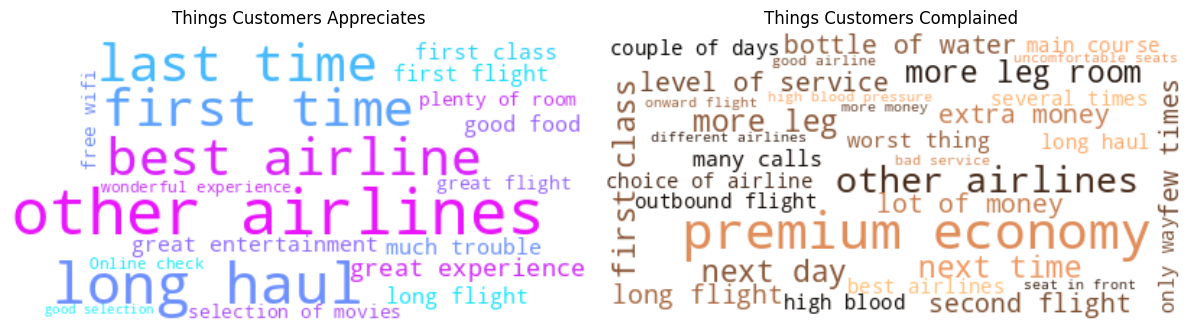

In [ ]:
## generating two word cloud
# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
wordcloud1 = WordCloud(background_color='white', colormap='cool', min_font_size=8).generate_from_frequencies(tips_good)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Things Customers Appreciates')

wordcloud2 = WordCloud(background_color='white', colormap='copper', min_font_size=8).generate_from_frequencies(tips_bad)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Things Customers Complained')

# Adjust the spacing between subplots
plt.tight_layout()

Here's an improved version of your writing:

Now we see more information regarding aspects customers appreciated and complained about.

**Positive Reviews**:
Customers appreciate several aspects of the airline, such as:
- Good selection of movies for in-flight entertainment
- Convenient online check-in service
- Tasty food offered during the flight

The customers providing positive reviews are likely to be first-time customers who were pleasantly surprised by their experience.

**Negative Reviews**:
On the other hand, customers had various complaints, including:
- Poor service received from the airline staff
- Insufficient legroom, leading to discomfort during the flight
- Uncomfortable seats that did not provide adequate support
- Feeling that the airline was not worth the money paid
- Possible racist behavior exhibited by the airline staff

The customers expressing these complaints are likely those who traveled in first class and premium economy, as they have higher expectations for their travel experience.

Interestingly, we noticed the phrase "high blood pressure" appearing in the negative reviews. It raises the question of what specific factors might have caused customers to experience high blood pressure during their flights. To investigate this further, let's print out the actual reviews that contain the words "high blood" and analyze the context in which they are mentioned.

In [ ]:
## check out high blood
mask = data['text'].apply(lambda x: 'high blood' in x)
for i in data[mask]['text']:
    pprint(i)

('Respected Faculty, I am Bincy, writing this  to file a complaint regarding a '
 'cancellation of the connection flight of Singapore airlines and the '
 'irresponsible service from Singapore airlines airport staff members at '
 'Singapore .My parents 67 yr old Dad as 63 yr old Mom travelled from Brisbane '
 'airport in Singapore airlines  SQ236 yesterday at 14.45 hrs and arrived at '
 'Singapore airport at 20.25hrs yesterday late evening. Then only they were '
 'informed that the connection flight SQ 536 which was booked and  confirmed, '
 'has got cancelled and they have to wait until next day night. This was not '
 'informed to us in any form of communication. \n'
 'And secondly, though my parents are very older with so many health issues, '
 '(my parents are Diabetic also, taking insulin and my parents have high blood '
 'pressure, taking medications)but they had to wait in airport in a chair '
 'without any support for 24 hours without any food especially when they are '
 'from a 

 - We see that those instances are both customers complaining about not receiving the proper medical care when waiting. Definate something the airline need to improve in the future.

It's important to note that **reviewing the original customer feedback is always helpful when interpreting NLP results**. By examining the specific context and details provided in the reviews, we can gain a clearer understanding of the situations described and draw more accurate conclusions. The original reviews offer valuable insights that can help us better summarize and make sense of the NLP analysis.

## Predictive Analysis

Now, let's try out the predictive analysis such as sentiment prediction. We will try different methods and compare their performances.

Here is a list of methods we are going to try.

- Dictionary
- BOW + RandomForest
- TFIDF + RandomForest
- Pretrained Naive Bayes (TextBlob)
- Glove Word Embeddings + RandomForest
- Glove Word Embeddings + LSTM
- Pretrained RoBERTa-large for sentiment analysis

In [ ]:
## setting up feature and target
data['sentiment'] = data['rating'].apply(lambda x: 1 if x > 3 else 0)  # convert rating into binary, 1 if >3 else 0

X = data['content_all'].values
Y = data['sentiment'].values.ravel()

## train test split
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(8000,) (2000,) (8000,) (2000,)


In [ ]:
## this is a binary classification problem, we will use accuracy
## let's check the default accuray by gussing all reviews are positive

default_accuracy = Y.mean()
print("The model is only meaningful when accuracy is above ",default_accuracy)

## Let's also initialize a dictionary to save the performance metric
performance = {"Default Accuracy": Y.mean()}
print(performance)

The model is only meaningful when accuracy is above  0.7391
{'Default Accuracy': 0.7391}


### Dictionary

The most primitive way to do sentiment analysis will be using counting the number of positive and negative words in the reviews with a dictionary. Let's try how it perform in our dataset.

In [ ]:
## load dictionary
def load_dictionary(file_path):
    # Load the dictionary from the file and save as dict object for fast searching
    with open(file_path, 'r') as f:
        dictionary = set(line.strip() for line in f.readlines())
    return dictionary

positive_words = load_dictionary('positive-words.txt')
negative_words = load_dictionary('negative-words.txt')

print(list(positive_words)[:10])
print(list(negative_words)[:10])

['sustainability', 'ideal', 'hardy', 'fantastic', 'improvement', 'unabashed', 'remarkably', 'fortuitously', 'noiseless', 'pure']
['head-aches', 'bearish', 'buzzing', 'fretful', 'obsessively', 'unlamentably', 'egotistically', 'hells', 'unseemly', 'unwillingness']


In [ ]:
## sentiment analysis with a dictionary

def sentiment_dictionary(text, positive_words, negative_words):
    # Split the text into individual words
    words = text.lower().split()

    # Count the number of positive and negative words
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)

    # Calculate the likelihood of the sentence being positive
    if positive_count + negative_count > 0:
        likelihood = positive_count / (positive_count + negative_count)
        if likelihood >= 0.5:
            sentiment = 1
        else:
            sentiment = 0
    else:
        # If no positive or negative words found, give a random guess
        likelihood = np.random.rand()
        if likelihood >= 0.5:
            sentiment = 1
        else:
            sentiment = 0

    return sentiment

In [ ]:
## test
print(sentiment_dictionary("I love this movie!", positive_words, negative_words))
print(sentiment_dictionary("I hate this movie!", positive_words, negative_words))
print(sentiment_dictionary("This movie is about US!", positive_words, negative_words))

1
0
0


In [ ]:
## Check the dictionary approach's performance
from sklearn.metrics import accuracy_score

y_pred = [sentiment_dictionary(text, positive_words, negative_words) for text in X_test]
accuracy = accuracy_score(Y_test, y_pred)
performance["Dictionary"] = accuracy

In [ ]:
print(pd.DataFrame(performance.items(), columns=["Method", "Accuracy"]))

             Method  Accuracy
0  Default Accuracy    0.7391
1        Dictionary    0.8370


- As we can see, the accuracy achieved using the dictionary approach is quite impressive, surpassing random guessing by 9.7%. This indicates that carefully curated keywords can effectively capture the sentiment expressed in the text.
- It's important to keep in mind that the accuracy of the dictionary approach heavily relies on the quality and relevance of the keywords you include. If the accuracy seems low, don't get discouraged. Instead, focus on refining and expanding the set of keywords to better represent the sentiment in your specific context.
- However, it's worth noting that the dictionary approach may have limitations when dealing with large and diverse text corpora, especially when the meaning of the text is highly dependent on its context. In such cases, a Bag-of-Words model can be a more effective solution. Let's explore how this model can help tackle these challenges.

### Bag-of-Words with Random Forest Classifer

In [ ]:
# create a bag of word model for sentiment analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# create a bag of words model
vectorizer = CountVectorizer(stop_words="english")

# fit the model on the training data
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# check the features and shape of X_train_bow
print(vectorizer.get_feature_names_out()[:10])
print(X_train_bow.shape)



['00' '000' '000ft' '0010' '0011' '0025' '0045' '00520' '008' '00am']
(8000, 17696)


In [ ]:
X_train_bow

<8000x17696 sparse matrix of type '<class 'numpy.int64'>'
	with 321748 stored elements in Compressed Sparse Row format>

In above, we built a BOW representation of the document with 17,696 features (keywords).

In [ ]:
# Assume X_train_bow and Y_train are already defined and prepared
model = RandomForestClassifier()
model.fit(X_train_bow, Y_train)

# Estimating performance on a test set (if available)
y_pred = model.predict(X_test_bow)
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8775


In [ ]:
y_pred

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
print(pd.DataFrame(performance.items(), columns=["Method", "Accuracy"]))

             Method  Accuracy
0  Default Accuracy    0.7391
1        Dictionary    0.8370


We see that the BOW continue to improve the model performance by 4%!

But when checking the features, we see a lot numerical values that may not be hold as important as other more relevant features. Let's try whether adding TF-IDF will improve its results.

In [ ]:
# Access the first row and specific columns
first_row = data.loc[0, ['content_all', 'sentiment']]

first_row
first_row_df = pd.DataFrame([first_row])

first_row_df

,content_all,sentiment
0,Ok ||||| We used this airline to go from Singa...,0


### TFIDF + RandomForest

### Practice 2 - Build a Random Forest Classifier based on TF-IDF method

TF-IDF is a weighted version of BOW that puts more weights on keywords that are unique to the specific documents.

`sklearn` has the buildin `TF-IDF Vectorizer` that work exactly the same as the BOW example above. Check the document and try out by yourself!

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
## your code here

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

#Create a bag of word model

vectorizer = TfidfVectorizer (stop_words = "english")

vectorizer

#fit the model on the trainning data

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# train a random forest classifier

model = RandomForestClassifier()
model.fit(X_train_tfidf, Y_train)

#Estimate performance

y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score (Y_test, y_pred)
performance ["TF-IDF + RandomForest"] = accuracy

In [ ]:
print(pd.DataFrame(performance.items(), columns=["Method", "Accuracy"]))

                  Method  Accuracy
0       Default Accuracy    0.7391
1             Dictionary    0.8370
2  TF-IDF + RandomForest    0.8760


- You will see a slight improvement over BOW, which is understandable. TF-IDF usually works better on tasks such as topic classification where the rare keywords play a big role in determine the topic of the document.

### Pretrained Naive Bayes (TextBlob)

Now you know how to do sentiment analysis with the classic BOW and TF-IDF approach. You can apply the same logic for other text classification tasks such as topic prediction, classify whether spam, classify whether fake reviews or not.

For popular tasks such as sentiment analysis, there are many pre-trained model help you speed up the process. For example, a popular choice in python is to use **TextBlob** package that contains a pre-trained Naive Bayes classifier to do sentiment analysis.

Let's check it out!

In [ ]:
from textblob import TextBlob

In [ ]:
## test
text = 'I had a really horrible day!'
blob = TextBlob(text)
blob.sentiment

Sentiment(polarity=-1.0, subjectivity=1.0)

In [ ]:
## define a function to use textblob to make sentiment prediction
## the model's prediction will be saved in "polarity" score, which ranges from -1 (very negative) to +1 (very positive)

def sentiment_textblob(text):
    blob = TextBlob(text)
    if blob.sentiment.polarity >=0:
        return 1
    else:
        return 0

In [ ]:
## Check the performance of TextBlob
y_pred = [sentiment_textblob(text) for text in X_test]
accuracy = accuracy_score(Y_test, y_pred)
performance["Pretrained Naive Bayes (TextBlob)"] = accuracy

In [ ]:
print(pd.DataFrame(performance.items(), columns=["Method", "Accuracy"]))

                              Method  Accuracy
0                   Default Accuracy    0.7391
1                         Dictionary    0.8370
2              TF-IDF + RandomForest    0.8760
3  Pretrained Naive Bayes (TextBlob)    0.8335


- Well, it's better than the default guesss, but worse than the dictionary approach 😂. Consider we don't need to actually train the model, it's probably okay to use it when we want some quick and not too bad results or we don't have a labeled dataset to train our model.

### Glove Word Embeddings

Now, let's see something a little bit more advanced -- word embedding!


In [ ]:
## load pre-trained word embeddings

from torchtext.vocab import GloVe

embedding_name = '6B'  # 'glove.6B.100d'
vec = GloVe(name=embedding_name, dim=100)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.33MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18252.57it/s]


In [ ]:
embedding_name

'6B'

- In class, we talked about that word embedding is a vector representation over the word's meaning. Let's check it out here with some sample words.

In [ ]:
words = ['Athlete', 'Competition', 'Team', 'Coach', 'Stadium', 'Training', 'Championship', 'Football', 'Referee', 'Tournament',  ## sports related
         'Budget', 'Investment', 'Portfolio', 'Stock', 'Bond', 'Dividend', 'Interest', 'Accounting', 'Bloomberg', 'Fiscal']  ## finance related
word_embeddings = vec.get_vecs_by_tokens(words, lower_case_backup=True)
print(word_embeddings.shape)

torch.Size([20, 100])


In [ ]:
print("Word embedding for Athlete \n", word_embeddings[0])

Word embedding for Athlete 
 tensor([ 1.0620e+00,  6.3725e-01,  1.7210e-01, -1.3294e-01, -6.7621e-01,
         1.6378e-01,  5.6488e-02, -9.1890e-02, -5.0579e-01,  4.2447e-01,
        -1.9986e-01, -1.3481e-01,  7.2268e-01, -3.4358e-01, -7.7404e-01,
         3.4925e-01,  3.2602e-01,  6.7368e-01, -5.5748e-01,  2.4577e-01,
        -7.8972e-01,  6.3363e-01, -1.1514e-03,  3.6792e-01,  1.7134e-01,
         1.3863e-01, -3.3292e-01, -9.1663e-01,  5.8413e-01, -1.5818e-01,
        -5.8458e-01,  8.3439e-01,  9.1777e-02, -1.6025e-01,  9.1233e-01,
        -2.9905e-01, -1.0966e+00,  1.0568e+00, -9.0113e-01,  6.7082e-01,
        -4.4734e-01,  7.0311e-01,  4.5349e-01, -8.9287e-01,  1.2685e-01,
         3.3069e-01,  4.9536e-01, -8.6480e-01, -4.9264e-02, -6.3279e-01,
        -7.5513e-02, -1.5299e-01,  6.9438e-01,  5.8336e-01,  2.4578e-01,
        -1.1802e+00, -7.4370e-01,  4.5760e-01,  1.0179e+00,  6.3751e-02,
         5.8371e-02,  2.1495e-01, -2.5839e-01,  5.1887e-01,  7.2421e-01,
        -6.8324e-02,  

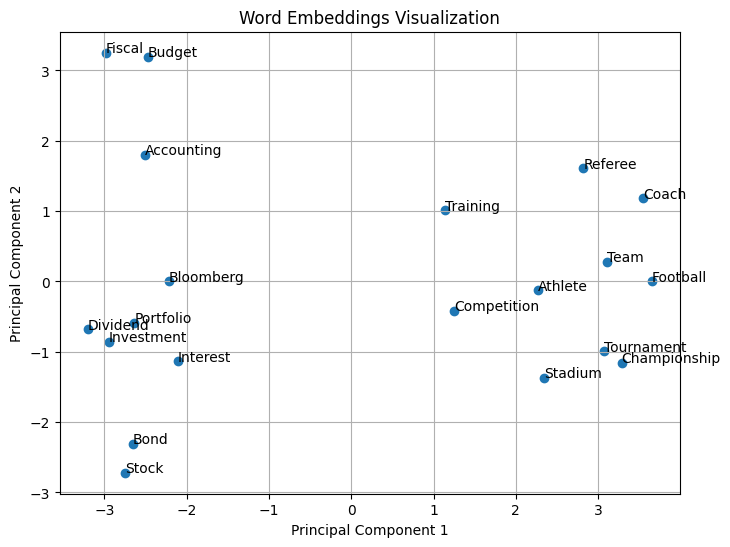

In [ ]:
## let's visualize them in a 2D space

# Perform PCA to reduce the dimensionality to 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_embeddings)

# Create a scatter plot of the word embeddings
plt.figure(figsize=(8, 6))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Word Embeddings Visualization')
plt.grid(True)

We see that the sports related words are all scattered on the right and the finance related words are all scattered on the left. **That's the power of word embeddings!**

Now, play around the word embeddings yourself with more words!

### Practice 3 - Calculate Cosine Similarity Using Word Embeddings

Word embeddings are very powerful tool for finding how similar words or sentences are. Now, try to calculate the pair-wise cosine similarities for all words and all sentences from list A and list B.

The cosine similarity goes from -1 to 1:
- 1 means the vectors are very similar
- 0 means the vectors are not related
- -1 means the vectors are very different

For sentences, you may want to write a function to calculate average word embeddings. This will take the following steps:
1. Get the word embeddings for each word.
2. Take the average of all the word embeddings in the sentence.
3. Use the average to calculate the cosine similarity between sentences.

Averaging the word embeddings gives you a way to represent the overall meaning of the sentence, so you can compare sentences based on how similar they are in meaning.

If a word isn't in the pre-trained word embeddings, you can either ignore it or use a `np.zeros(100)` to replace it. Have fun!

In [ ]:
## your code here

from sklearn.metrics.pairwise import cosine_similarity

A = ['Election', 'Democracy', 'Government', 'Policy', 'Diplomacy', 'Soccer', 'Basketball', 'Tennis', 'Baseball', 'Volleyball']
B = ['Hollywood Box Office: "Avatar: The Way of Water" Sets New Opening Weekend Record',
     'Tesla Stock Surges After Q4 Profit Report Beats Expectations',
     'Microsoft Unveils ChatGPT Integration in Edge Browser',
     'Apple Reports Strong Quarterly Revenue Growth',
     'Netflix Announces Release Date for Stranger Things Season 4',
     'Elon Musk Acquires Twitter Amid Controversy']


In [ ]:
word_embeddings = vec.get_vecs_by_tokens(A,lower_case_backup=True)

simi_A = cosine_similarity (word_embeddings)

simi_A

array([[0.99999994, 0.5161721 , 0.6330343 , 0.5097347 , 0.2501779 ,
        0.22694075, 0.16422959, 0.15363802, 0.24105105, 0.08412977],
       [0.5161721 , 0.99999994, 0.5792781 , 0.5171927 , 0.41218257,
        0.2337643 , 0.17188753, 0.21385643, 0.23710378, 0.12819418],
       [0.6330343 , 0.5792781 , 0.9999998 , 0.6765172 , 0.3579969 ,
        0.27636036, 0.14425509, 0.14443268, 0.24686027, 0.03904974],
       [0.5097347 , 0.5171927 , 0.6765172 , 1.0000004 , 0.6141489 ,
        0.22898728, 0.21866927, 0.11967799, 0.23619676, 0.06358599],
       [0.2501779 , 0.41218257, 0.3579969 , 0.6141489 , 0.99999994,
        0.17524752, 0.1747827 , 0.12969235, 0.10616046, 0.07319574],
       [0.22694075, 0.2337643 , 0.27636036, 0.22898728, 0.17524752,
        1.0000001 , 0.80039704, 0.7036358 , 0.70282817, 0.76900077],
       [0.16422959, 0.17188753, 0.14425509, 0.21866927, 0.1747827 ,
        0.80039704, 1.        , 0.67152345, 0.7645362 , 0.7434347 ],
       [0.15363802, 0.21385643, 0.1444326

In [ ]:
simi_A = pd.DataFrame (simi_A, columns = A, index = A)
simi_A.style.background_gradient(cmap = 'coolwarm')

,Election,Democracy,Government,Policy,Diplomacy,Soccer,Basketball,Tennis,Baseball,Volleyball
Election,1.000000,0.516172,0.633034,0.509735,0.250178,0.226941,0.164230,0.153638,0.241051,0.084130
Democracy,0.516172,1.000000,0.579278,0.517193,0.412183,0.233764,0.171888,0.213856,0.237104,0.128194
Government,0.633034,0.579278,1.000000,0.676517,0.357997,0.276360,0.144255,0.144433,0.246860,0.039050
Policy,0.509735,0.517193,0.676517,1.000000,0.614149,0.228987,0.218669,0.119678,0.236197,0.063586
Diplomacy,0.250178,0.412183,0.357997,0.614149,1.000000,0.175248,0.174783,0.129692,0.106160,0.073196
Soccer,0.226941,0.233764,0.276360,0.228987,0.175248,1.000000,0.800397,0.703636,0.702828,0.769001
Basketball,0.164230,0.171888,0.144255,0.218669,0.174783,0.800397,1.000000,0.671523,0.764536,0.743435
Tennis,0.153638,0.213856,0.144433,0.119678,0.129692,0.703636,0.671523,1.000000,0.532834,0.755409
Baseball,0.241051,0.237104,0.246860,0.236197,0.106160,0.702828,0.764536,0.532834,1.000000,0.523918
Volleyball,0.084130,0.128194,0.039050,0.063586,0.073196,0.769001,0.743435,0.755409,0.523918,1.000000


From the heatmap, government has the highest coisine similarity with policy. And soccer has the highest coisine similarity with basketball.

In [ ]:
import numpy as np

def calculate_average_word_embedding(sentence, vec):
    """
    Calculate the average word embedding for a list of words.
    """
    words = sentence.lower().split()
    embeddings = vec.get_vecs_by_tokens(words, lower_case_backup=True)
    if embeddings.shape[0] == 0:
        return np.zeros(100)
    return np.mean(embeddings.numpy(), axis=0)

embeddings_B = [calculate_average_word_embedding(sentence, vec) for sentence in B]

In [ ]:
embeddings_B

[array([ 8.07830766e-02,  1.40979206e-02,  5.26081979e-01, -9.47899967e-02,
         1.91384777e-01,  1.35340154e-01, -1.54820174e-01,  2.27146700e-01,
        -4.54206973e-01, -4.57051992e-02,  1.42663851e-01, -1.76156536e-01,
        -5.44978455e-02, -1.03707495e-03,  8.37852284e-02,  5.76433018e-02,
         2.15746954e-01,  1.02602996e-01, -2.00078487e-02,  3.81876412e-03,
         2.95726657e-01,  5.16015291e-03,  1.75336987e-01, -5.00684753e-02,
         3.27058524e-01, -1.61519229e-01,  8.11828449e-02, -1.92066908e-01,
        -6.49834573e-02, -2.35721558e-01, -1.00329384e-01,  1.67598858e-01,
         7.04849288e-02,  8.30483809e-02, -9.93668381e-03,  4.54334617e-02,
        -6.67322353e-02,  2.92386971e-02, -1.06176004e-01, -1.35293543e-01,
        -2.03756005e-01, -2.84436166e-01,  7.90639222e-02, -5.62094636e-02,
         1.26351148e-01, -6.39775395e-02, -3.61701474e-02, -3.66887838e-01,
         1.16926365e-01, -4.40974444e-01,  5.82978353e-02, -1.12138994e-01,
         1.1

In [ ]:
simi_B = cosine_similarity (embeddings_B)

simi_B = pd.DataFrame (simi_B, columns = B, index = B)

simi_B.style.background_gradient (cmap = 'coolwarm')

,"Hollywood Box Office: ""Avatar: The Way of Water"" Sets New Opening Weekend Record",Tesla Stock Surges After Q4 Profit Report Beats Expectations,Microsoft Unveils ChatGPT Integration in Edge Browser,Apple Reports Strong Quarterly Revenue Growth,Netflix Announces Release Date for Stranger Things Season 4,Elon Musk Acquires Twitter Amid Controversy
"Hollywood Box Office: ""Avatar: The Way of Water"" Sets New Opening Weekend Record",1.000000,0.659090,0.702888,0.687016,0.860424,0.328546
Tesla Stock Surges After Q4 Profit Report Beats Expectations,0.659090,1.000000,0.581374,0.866382,0.670922,0.442701
Microsoft Unveils ChatGPT Integration in Edge Browser,0.702888,0.581374,1.000000,0.681660,0.668098,0.441961
Apple Reports Strong Quarterly Revenue Growth,0.687016,0.866382,0.681660,1.000000,0.704422,0.477762
Netflix Announces Release Date for Stranger Things Season 4,0.860424,0.670922,0.668098,0.704422,1.000000,0.441205
Elon Musk Acquires Twitter Amid Controversy,0.328546,0.442701,0.441961,0.477762,0.441205,1.000000


Netflix Announces Release Date for Stranger Things Season 4 has the highest cosine similarity with Hollywood Box Office: "Avatar: The Way of Water" Sets New Opening Weekend Record.

### Practice 4 - Word Embedding + Random Forest

Now, let's try to use the word embeddings for sentiment analysis.

The simplest way to do that is to use the average sentence embedding as features, then use a classic machine learning model to make prediction.

Since you have already write a function calculate average sentence embedding, try to use it to process the X_train and X_test, then build a Random Forest Classifier to make prediction.

Let me know how your model performs!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Function to calculate average sentence embedding
def calculate_average_sentence_embedding(sentences, vec):
    """
    Calculate the average sentence embedding for a list of sentences.
    """
    # Initialize an empty array to store sentence embeddings
    sentence_embeddings = []
    for sentence in sentences:
        words = sentence.lower().split()
        embeddings = vec.get_vecs_by_tokens(words, lower_case_backup=True)
        if embeddings.shape[0] == 0:
            sentence_embeddings.append(np.zeros(100))
        else:
            sentence_embeddings.append(np.mean(embeddings.numpy(), axis=0))
    return np.array(sentence_embeddings)

# Calculate average sentence embedding for training and test data
X_train_embeddings = calculate_average_sentence_embedding(X_train, vec)
X_test_embeddings = calculate_average_sentence_embedding(X_test, vec)

# Train a random forest classifier
model = RandomForestClassifier()
model.fit(X_train_embeddings, Y_train)

# Make predictions
y_pred = model.predict(X_test_embeddings)

# Estimate performance
accuracy = accuracy_score(Y_test, y_pred)
performance["Average Embedding + RandomForest"] = accuracy

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
print(pd.DataFrame(performance.items(), columns=["Method", "Accuracy"]))

                              Method  Accuracy
0                   Default Accuracy    0.7391
1                         Dictionary    0.8370
2              TF-IDF + RandomForest    0.8760
3  Pretrained Naive Bayes (TextBlob)    0.8335
4   Average Embedding + RandomForest    0.8315


- It's likely you will see an accuracy score about the same as BOW or TF-IDF.
- This is because most reviews here are pretty long, and averaging them will make the embeddings gravitate towards zeros. It's nice to learn that! So, next time trying out this approach, use it on short sentences!

### Fine Tune a BERT model

Despite that I want to build a RNN or LSTM from scratch, I found the model easiy overfit, probably because the training samples are too small (N=8,000). Since this involves lengthy code and a very long training time, I will not overwhelm you with my experiment.

So, let's try something even cooler -- fine tune a BERT model!

BERT is a Transformer encoder that has already been trained using a very big dataset, so its weights are well-calibrated. This enables it to make accurate prediction with a little bit of fine tuning with small training dataset. 8,000 is more than enough in our case.

Let's try it out!

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import torch
from transformers import AutoTokenizer
from datasets import Dataset

In [ ]:
## check if cuda is avaliable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("training with:", device)

training with: cpu


In [ ]:
 train_dataset = [dict(text=text, label=label) cho văn bản, nhãn ở dạng zip(X_train, Y_train)]
  test_dataset = [dict(text=text, label=label) cho văn bản, nhãn ở dạng zip(X_test, Y_test)]

   train_dataset = Dataset.from_list(train_dataset)Bạn đang trên đường đến quận tiểu học vâng lệnh đã biến mất John book of my Way live có lẽ họ sẽ đặt thứ gì đó hoặc thứ gì đó này
    test_dataset=Bộ dữ liệu.from_list(test_dataset)

In [ ]:
## this is how the dataset looks like
train_dataset[0]

{'text': 'Fabulous as always ||||| I have flown many times with Singapore Airlines and once again I had great flights, friendly efficient service.\nThe success of a great flight for me is to be able to sleep on the overnight legs, and I did.\nAlthough wasn’t that impressed with the movies selevtion this month. but could have been a slow month for the new realeases that would interest me.\nThank you',
 'label': 1}

In [ ]:
## initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(data):
    return tokenizer(data['text'], padding="max_length", truncation=True)

## tokenize data
tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)

## since fine tune takes a long time, I will randomly sample a subset for training
## in practice, you can use training sets  2000 < N < 100000, based on how difficult your problem is
tokenized_sample_train = tokenized_train_datasets.shuffle(seed=42).select(range(2000))  # randomly sample 2000 for training
tokenized_sample_test = tokenized_test_datasets.shuffle(seed=42).select(range(500))  # randomly sample 500 for validating during the training

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  # Means the user did not define a `HF_TOKEN` secret => warn


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate
import accelarate

In [ ]:
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=2).to(device)
metric = evaluate.load("accuracy")

# use accuracy as evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## specify the training parameters
training_args = TrainingArguments(output_dir="test_trainer",
                                  num_train_epochs=2,   # total 2 epochs
                                  evaluation_strategy="steps",
                                  eval_steps=100)    # evaluate every 100 steps
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_sample_train,
    eval_dataset=tokenized_sample_test,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
# evaluate the model on all testing dataset
predictions = trainer.predict(tokenized_test_datasets)
print(predictions.predictions.shape, predictions.label_ids.shape)

y_pred = np.argmax(predictions.predictions, axis=-1)
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)
performance["FineTuned BERT"] = accuracy

(2000, 2) (2000,)
Accuracy: 0.921


In [ ]:
print(pd.DataFrame(performance.items(), columns=["Method", "Accuracy"]))

,Method,Accuracy
0,Default Accuracy,0.7391
1,Dictionary,0.8380
2,BOW + RandomForest,0.8680
3,TF-IDF + RandomForest,0.8750
4,Pretrained Naive Bayes (TextBlob),0.8335
5,WordEmbeddings + RandomForest,0.8415
6,FineTuned BERT,0.9210


- You see that the fine tuned BERT can easily surpass traditional ML models with very few training dataset (just 2,000 instances)! Increase the size of the training dataset will probably get you even higher accuracy, try out yourself with all avaliable training instances (N=8,000) and see how it performs if you are interested! (Note: do this after class, it will take some time)

- That's why BERT is the current **state-of-the-art** approach for simple NLP tasks! Similarly, you can also fine tune a BERT for other text classification tasks!

### RoBERTa

For a common task like sentiment analysis, people probably have already fine tuned a BERT already and host it somewhere.

If you want easy sentiment analysis with high accuracy and **have access to a GPU**, you may download a pre-trained model specificly for sentiment analysis from HuggingFace, checkout this RoBERTa-large model that fine tuned for sentiment analysis.

Model address: https://huggingface.co/siebert/sentiment-roberta-large-english

In [ ]:
from transformers import pipeline

## initialize the model pipeline
RoBERTa_sentiment = pipeline(model="siebert/sentiment-roberta-large-english", truncation=True, device=device)

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
print(RoBERTa_sentiment("I love this!"))
print(RoBERTa_sentiment("I don't like this!"))

[{'label': 'POSITIVE', 'score': 0.9988656044006348}]
[{'label': 'NEGATIVE', 'score': 0.9994779229164124}]


In [ ]:
## Check the performance of RoBERTa-sentiment on 100 testing instances
y_pred = [RoBERTa_sentiment(text) for text in X_test[:100]]  # only evaluating the first 100 test instances to save time
y_pred = [pred[0]['label'] for pred in y_pred]
y_pred = [1 if pred == 'POSITIVE' else 0 for pred in y_pred]
accuracy = accuracy_score(Y_test[:100], y_pred)
performance["RoBERTa-sentiment"] = accuracy

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
print(pd.DataFrame(performance.items(), columns=["Method", "Accuracy"]))

,Method,Accuracy
0,Default Accuracy,0.7391
1,Dictionary,0.8380
2,BOW + RandomForest,0.8680
3,TF-IDF + RandomForest,0.8750
4,Pretrained Naive Bayes (TextBlob),0.8335
5,WordEmbeddings + RandomForest,0.8415
6,FineTuned BERT,0.9210
7,RoBERTa-sentiment,0.9500


## Summary

Now you have seen the most frequently used NLP techniques for text classification (sentiment analysis in our case).

To summarize, we have
- No Machine Learning: Dictionary
- The Classic: BOW/TF-IDF with traditional ML model
- The Neural Network Approach: WordEmbedding + BERT(GPU needed)
- The fast and easy pre-trained models: TextBlob + RoBERTa-sentiment(GPU needed)

Hope you enjoy the learning!
